---
# Projeto 6: Pré-Processamento - Titanic
---

## Etapa 1: Importação das Bibliotecas

In [121]:
# region Bibliotecas
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import warnings

warnings.filterwarnings("ignore")
# endregion

In [122]:
# region Extras
# import importlib
#
# import modulos.estrategia2
#
# importlib.reload(modulos.estrategia2)

from modulos.estrategia1 import *
from modulos.estrategia2 import *
from modulos.estrategia3 import *

# endregion

In [123]:
def Stop():
    raise SystemExit("A célula foi interrompida para evitar a execução do código abaixo.")

## Etapa 2: Importação dos Dados

In [124]:
# region Importação do Dataset
fileTitanic = "dataset/titanic.csv"

if os.path.exists(fileTitanic):
    titanic = pd.read_csv(fileTitanic)
else:
    link = "https://drive.google.com/file/d/1FGE-R5tNMgQs8-_T2fKUFFEq43sFGTfx/view?usp=sharing"
    fileID = link.split("/d/")[1].split("/")[0]
    fileTitanic = "https://drive.google.com/uc?id=" + fileID
    titanic = pd.read_csv(fileTitanic)
# endregion

In [125]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [126]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.377387,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.484918,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [127]:
titanic.shape

(1309, 12)

## Etapa 3: Manipulação do Dataset

### Descrição das Colunas

>**Pclass:**
* Classe do passageiro (1 = 1ª classe, 2 = 2ª classe, 3 = 3ª classe)
***
>**SibSp:**
* Número de irmãos/cônjuges a bordo.
* 0 = O passageiro não estava acompanhado por irmãos ou cônjuges.
* 1 = O passageiro estava acompanhado por um irmão ou cônjuge.
* 2 ou mais: O passageiro estava acompanhado por múltiplos irmãos e/ou cônjuges.
***
>**Parch:**
* Número de pais/filhos a bordo.
* 0 = Sem pais/filhos.
* 1 = O passageiro estava acompanhado por um pai ou filho.
* 2 ou mais: O passageiro estava acompanhado por múltiplos pais e/ou filhos.


### Encoding

In [128]:
# region Encoding com LabelEncoder
def encodeLabel(data, cols):
    encoderLabel = LabelEncoder()

    data = data.dropna(subset=cols)

    for col in cols:
        sum = 1 if col == "Embarked" else 0
        data[col] = encoderLabel.fit_transform(data[col]) + sum

    return data

# endregion

In [129]:
# Sex: 0 - Feminino, 1 - Masculino
# Embarked: 1 - C, 2 - Q, 3 - S (Cherbourg, Queenstown, Southampton)
titanic = encodeLabel(titanic, ["Sex", "Embarked"])

### Tratamento de Dados Faltantes

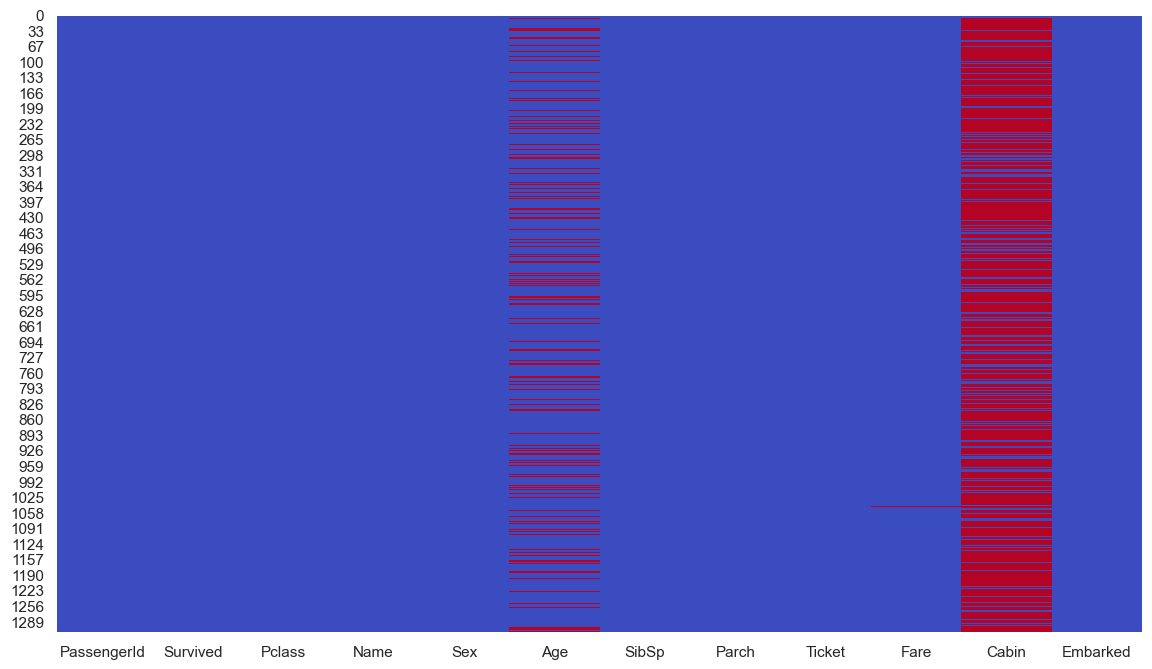

In [130]:
plt.figure(figsize=(14, 8), dpi=100)

sns.heatmap(titanic.isna(), cbar=False, cmap="coolwarm");

In [131]:
calcPercentualValoresAusentes(titanic)

O dataset tem 8.15 % de valores ausentes.


In [132]:
calcPercentualValoresAusentesLinha(titanic)

79.34 % das linhas no conjunto de dados contêm pelo menos um valor ausente.


In [133]:
calcPercentualValoresAusentesColuna(titanic)

O dataset tem 12 colunas.
Encontrado: 3 colunas que têm valores ausentes.


,Valores Ausentes,% de Valores Ausentes,Dtype
Cabin,1014,77.58,object
Age,263,20.12,float64
Fare,1,0.08,float64


In [134]:
# Drop de colunas com mais de 30% de valores ausentes
dropColumns(titanic, ["Cabin"])

1 coluna foi descartada.


### Tratamento de Dados na coluna "Age"

In [135]:
# region Funções com modelos para previsão de valores ausentes
def optimizeLinearModel(X, y, seed=42):
    # Divisão do conjunto de dados em treino e teste
    train_X, test_X, train_y, test_y = train_test_split(
        X, y, test_size=0.2, random_state=seed, shuffle=True
    )

    # Construção do pipeline
    pipe = Pipeline(
        [
            # Normalização dos dados
            ("scaler", StandardScaler()),
            # Interações não lineares
            ("poly", PolynomialFeatures()),
            # Regressão linear com regularização
            ("model", Ridge()),
        ]
    )

    # Definição dos parâmetros para o tuning
    params = {
        # Grau das interações polinomiais
        "poly__degree": [1, 2, 3],
        # Intensidade da regularização
        "model__alpha": [0.01, 0.1, 1, 10, 100],
        # Incluir intercepto
        "model__fit_intercept": [True, False],
        # Normalizar com média
        "scaler__with_mean": [True, False],
    }

    # Configuração do GridSearchCV
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=params,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        verbose=0,
    )

    # Treinamento com validação cruzada
    grid.fit(train_X, train_y)

    # Predição no conjunto de teste
    pred_y = grid.best_estimator_.predict(test_X)

    # Avaliação do modelo
    mse = mean_squared_error(test_y, pred_y)
    r2 = r2_score(test_y, pred_y)

    # Resultados
    print(f"\nMelhor MSE: {mse:.4f}")
    print(f"R² no teste: {r2:.4f}")
    print(f"Melhores Parâmetros: {grid.best_params_}")

    # Retornar o melhor modelo ajustado
    return grid.best_estimator_


def optimizeXGBoostModel(X, y, seed=42):
    train_X, test_X, train_y, test_y = train_test_split(
        X, y, test_size=0.2, random_state=seed, shuffle=True
    )

    model = XGBRegressor(random_state=seed, use_label_encoder=False)
    params = {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 5, 10],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
        "gamma": [0, 1, 5],
    }

    grid = GridSearchCV(
        estimator=model,
        param_grid=params,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        verbose=0,
    )

    grid.fit(train_X, train_y)
    pred_y = grid.best_estimator_.predict(test_X)

    mse = mean_squared_error(test_y, pred_y)
    r2 = r2_score(test_y, pred_y)

    print(f"\nMelhor MSE: {mse:.4f}")
    print(f"R² no teste: {r2:.4f}")
    print(f"Melhores Parâmetros: {grid.best_params_}")

    return grid.best_estimator_


# endregion
# endregion

In [136]:
# region Preprocessamento e Otimização do Modelo
def preprocessAndOptimizeModel(data):
    # Filtrar as linhas onde "Age" não é nulo e remover outras ausências
    complete = data[data["Age"].notna()]
    complete.dropna(inplace=True)

    # Selecionar variáveis numéricas (exceto "Age") como preditoras
    X = complete.select_dtypes(include=["number"]).drop(columns=["Age"])
    y = complete["Age"].astype(int)

    # Remover classes com menos de 2 exemplos
    counts = y.value_counts()
    valid_classes = counts[counts >= 2].index
    X = X[y.isin(valid_classes)]
    y = y[y.isin(valid_classes)]

    # Ajustar e otimizar o modelo XGBoost
    best_model = optimizeXGBoostModel(X, y)

    return best_model


# endregion

In [137]:
# region Tratamento de Dados Faltantes na coluna "Age"
def imputarValoresFaltantesIdade(data):
    # Divisão dos dados em completos e faltantes
    complete = data[data["Age"].notna()]
    missing = data[data["Age"].isna()]

    # Selecionar apenas variáveis numéricas (exceto 'Age') para predição
    X = complete.select_dtypes(include=["number"]).drop(columns=["Age"])
    y = complete["Age"].astype(int)

    # Remover classes com menos de 2 exemplos
    counts = y.value_counts()
    valid_classes = counts[counts >= 2].index
    X = X[y.isin(valid_classes)]
    y = y[y.isin(valid_classes)]

    # Configuração do modelo XGBoost
    xgb = XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
    )

    # Treinamento do modelo
    xgb.fit(X, y)

    # Selecionar as mesmas colunas para as linhas com valores faltantes
    missingFeatures = missing[X.columns]

    # Preencher os valores faltantes de 'Age'
    data.loc[data["Age"].isna(), "Age"] = xgb.predict(missingFeatures)

    return data


# endregion

In [138]:
# titanic = imputarValoresFaltantesIdade(titanic)

In [139]:
# Drop de linhas com valores ausentes
dropRowsWithMissingValues(titanic)

264 linhas contendo valores ausentes foram descartadas.


In [140]:
calcPercentualValoresAusentes(titanic)

O dataset tem 0.0 % de valores ausentes.


In [141]:
# region Agrupar os passageiros por faixa de idade
def groupAges(data, column="Age"):
    bins = [0, 18, 50, float("inf")]
    labels = ["Jovens (0-17)", "Adultos (18-50)", "Idosos (50+)"]

    data["AgeGroup"] = pd.cut(data[column], bins=bins, labels=labels, right=False)

    return data


# endregion

In [142]:
titanic = groupAges(titanic)

### Manipulação das demais Colunas

In [143]:
# region Tratamento da coluna "Name"
def splitNames(data, column="Name"):
    # Separar pelo caractere ','
    data[["LastName", "FirstName"]] = data[column].str.split(",", n=1, expand=True)

    # Remover pronomes de tratamento da coluna 'FirstName'
    data["FirstName"] = (
        data["FirstName"]
        .str.replace(r"(Mr\.|Mrs\.|Miss|Master|Dr\.)", "", regex=True)
        .str.strip()
    )

    # Remover quaisquer caracteres especiais e espaços extras
    data["LastName"] = (
        data["LastName"]
        # Remover caracteres especiais
        .str.replace(r"[^\w\s]", "", regex=True)
        # Remover espaços no início e no fim
        .str.strip()
        # Remover espaços extras no meio
        .str.replace(r"\s+", " ", regex=True)
    )

    data["FirstName"] = (
        data["FirstName"]
        # Remover caracteres especiais
        .str.replace(r"[^\w\s]", "", regex=True)
        # Remover espaços no início e no fim
        .str.strip()
        # Remover espaços extras no meio
        .str.replace(r"\s+", " ", regex=True)
    )

    return data


# endregion

In [144]:
titanic = splitNames(titanic, column="Name")

## Etapa 4: Feature Engineering

In [145]:
data = titanic.copy()

In [146]:
embarkedMapping = {1: "Cherbourg", 2: "Queenstown", 3: "Southampton"}

# Verificar se a coluna já foi mapeada
if data["Embarked"].dtype != "object":
		data["Embarked"] = data["Embarked"].map(embarkedMapping)

In [147]:
# region Contagem de Passageiros por Porto de Embarque
def passengerPercentageByPortAndClass(data):
    # Contagem total de passageiros por porto de embarque
    totalByPort = data.groupby("Embarked")["PassengerId"].count()

    # Contagem de passageiros por porto de embarque e classe
    passengersByPortAndClass = (
        data.groupby(["Embarked", "Pclass"])["PassengerId"].count().reset_index()
    )

    # Calcular a porcentagem
    passengersByPortAndClass["Porcentagem"] = passengersByPortAndClass.apply(
        lambda row: (row["PassengerId"] / totalByPort[row["Embarked"]]) * 100,
        axis=1,
    ).round(2)

    # Renomear colunas para melhor legibilidade
    passengersByPortAndClass.columns = [
        "Porto de Embarque",
        "Classe",
        "Quantidade",
        "Porcentagem (%)",
    ]

    return passengersByPortAndClass


# endregion

In [148]:
passengers = passengerPercentageByPortAndClass(data)

# Exibir os resultados
passengers


,Porto de Embarque,Classe,Quantidade,Porcentagem (%)
0,Cherbourg,1,128,60.38
1,Cherbourg,2,24,11.32
2,Cherbourg,3,60,28.30
3,Queenstown,1,3,6.00
4,Queenstown,2,5,10.00
5,Queenstown,3,42,84.00
6,Southampton,1,151,19.33
7,Southampton,2,232,29.71
8,Southampton,3,398,50.96


In [149]:
# region Plot de Sobreviventes/falecidos por Porto de Embarque
def plotPassengersEmbarked(data):
    # Mapeamento para coluna de sobrevivência
    data["sobreviveu"] = data["Survived"].map({0: "Não", 1: "Sim"})

    # Configuração do estilo do gráfico
    sns.set_theme(style="whitegrid", palette="pastel")

    # Criar o gráfico
    plt.figure(figsize=(10, 6), dpi=120)
    ax = sns.countplot(
        x="Embarked", hue="sobreviveu", data=data, palette=["darkred", "navy"], edgecolor="black"
    )

    # Adicionar as contagens às barras
    for bar in ax.patches:
        # Verificar se a barra é visível (altura maior que zero)
        if bar.get_height() > 0:
            # Calcular posição do texto
            xPos = bar.get_x() + bar.get_width() / 2
            height = bar.get_height()

            # Inserir texto com a contagem acima da barra
            ax.text(
                xPos,
                height + 2,
                f"{int(height)}",
                ha="center",
                va="bottom",
                fontsize=10,
                weight="bold",
            )

    # Personalizar título e rótulos
    ax.set_title(
        "Sobreviventes/Falecimentos por Porto de Embarque", fontsize=16, weight="bold"
    )
    ax.set_xlabel("Portos de Embarque", fontsize=14)
    ax.set_ylabel("Contagem", fontsize=14)

    # Ajustar tamanho dos rótulos
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)

    # Melhorar a posição da legenda
    ax.legend(title="Sobreviveu", fontsize=12, title_fontsize=13, loc="upper right")

    # Mostrar o gráfico com layout ajustado
    plt.tight_layout()
    plt.show()


# endregion

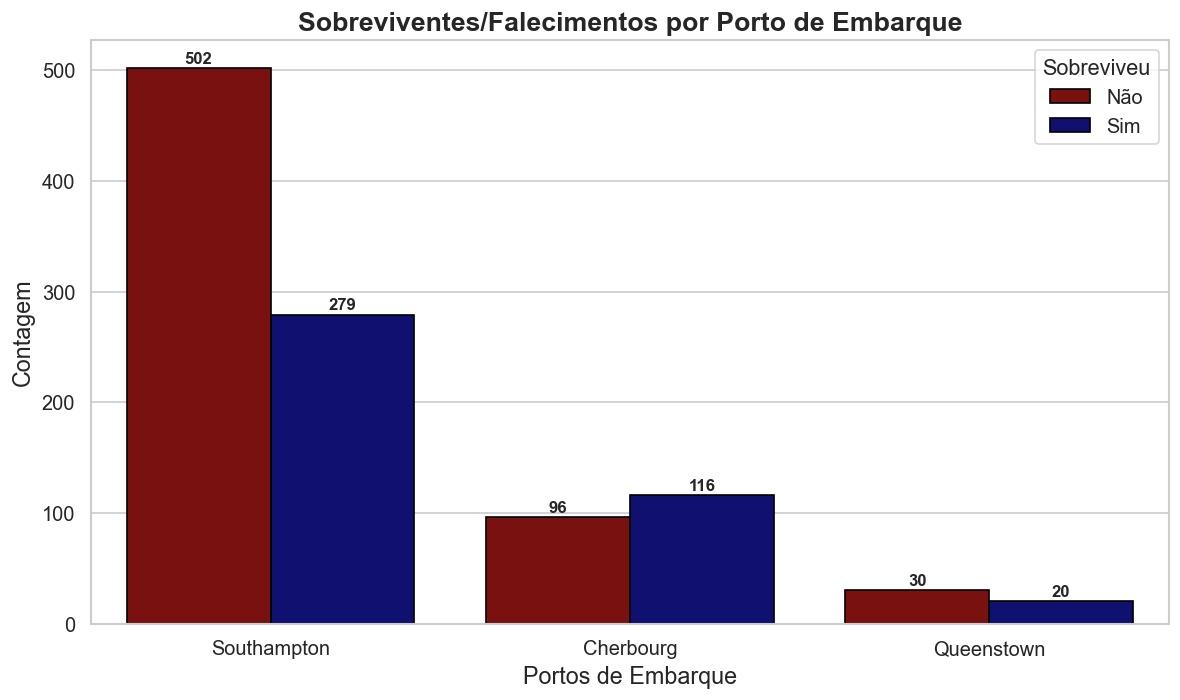

In [150]:
plotPassengersEmbarked(data)

In [151]:
# region Porcentagem de Falecimento por Porto de Embarque
def DeathPercentageByPort(data):
    # Filtrar passageiros que não sobreviveram (Survived == 0)
    deceasedByPort = data[data["Survived"] == 0].groupby("Embarked")["PassengerId"].count()

    # Total de passageiros por porto
    totalByPort = data.groupby("Embarked")["PassengerId"].count()

    # Calcular a porcentagem de passageiros que faleceram por porto
    percentageDeceasedByPort = (
        (deceasedByPort / totalByPort * 100).round(2).reset_index()
    )
    percentageDeceasedByPort.columns = ["Porto de Embarque", "Falecimentos (%)"]

    return percentageDeceasedByPort


# endregion

In [152]:
percentageDeceasedByPort = DeathPercentageByPort(data)

# Exibir os resultados
percentageDeceasedByPort

,Porto de Embarque,Falecimentos (%)
0,Cherbourg,45.28
1,Queenstown,60.00
2,Southampton,64.28


* Jack Dawson, interpretado por Leonardo DiCaprio, embarca no Titanic no porto de **Southampton**.
* Rose DeWitt Bukater, interpretada por Kate Winslet, também embarca no Titanic no porto de **Southampton**.

In [153]:
#region Porcentagem de Falecimentos por Porto e Classe
def PassengersByPortAndClass(data):
    # Total de passageiros por porto e classe
    totalByPortClass = data.groupby(["Embarked", "Pclass"])["PassengerId"].count().reset_index()
    totalByPortClass.columns = ["Porto de Embarque", "Classe", "Total de Passageiros"]

    # Filtrar passageiros que não sobreviveram (Survived == 0) e agrupar por porto e classe
    deceasedByPortClass = data[data["Survived"] == 0].groupby(["Embarked", "Pclass"])["PassengerId"].count().reset_index()
    deceasedByPortClass.columns = ["Porto de Embarque", "Classe", "Falecimentos"]

    # Combinar os dados de total de passageiros e falecimentos
    combinedData = totalByPortClass.merge(deceasedByPortClass, on=["Porto de Embarque", "Classe"], how="left")
    combinedData["Falecimentos"] = combinedData["Falecimentos"].fillna(0).astype(int)  # Substituir valores ausentes por 0

    # Calcular a porcentagem de falecimentos
    combinedData["Falecimentos (%)"] = (combinedData["Falecimentos"] / combinedData["Total de Passageiros"] * 100).round(2)

    # Reordenar as colunas para colocar "Falecimentos (%)" como última
    combinedData = combinedData[["Porto de Embarque", "Classe", "Total de Passageiros", "Falecimentos", "Falecimentos (%)"]]

    return combinedData

#endregion

In [154]:
percentageDeceasedByPortClass = PassengersByPortAndClass(data)

# Exibir os resultados
percentageDeceasedByPortClass

,Porto de Embarque,Classe,Total de Passageiros,Falecimentos,Falecimentos (%)
0,Cherbourg,1,128,48,37.50
1,Cherbourg,2,24,12,50.00
2,Cherbourg,3,60,36,60.00
3,Queenstown,1,3,1,33.33
4,Queenstown,2,5,4,80.00
5,Queenstown,3,42,25,59.52
6,Southampton,1,151,65,43.05
7,Southampton,2,232,133,57.33
8,Southampton,3,398,304,76.38


In [155]:
# region Passageiros que viajavam juntos
def PassengersTravelingTogether(data):
    # Agrupar passageiros com base no Ticket
    groupedTickets = data.groupby("Ticket")["PassengerId"].count()

    # Identificar tickets compartilhados por mais de uma pessoa
    sharedTickets = groupedTickets[groupedTickets > 1]

    # Total de pessoas que compartilhavam tickets
    totalShared = sharedTickets.sum()

    # Recriar `sharedGroups` para garantir que todas as colunas relevantes estão presentes
    sharedGroups = data[data["Ticket"].isin(sharedTickets.index)]

    # Mapear valores de 'Sex', se necessário
    if sharedGroups["Sex"].dtype in [int, float]:
        sharedGroups["Sex"] = sharedGroups["Sex"].map({0: "female", 1: "male"})

    totalBySexAll = sharedGroups.groupby("Sex")["PassengerId"].count()

    # Calcular o total de passageiros por sexo que viajavam juntos
    totalBySex = sharedGroups.groupby("Sex")["Survived"].count()

    # Calcular o total de sobreviventes por sexo
    survivedBySex = sharedGroups.groupby("Sex")["Survived"].sum()

    # Calcular a porcentagem de sobreviventes por sexo
    percentageSurvivedBySex = (survivedBySex / totalBySex * 100).round(2).reset_index()
    percentageSurvivedBySex.columns = ["Sex", "SurvivalPercentage"]

    # Exibir os resultados
    print(
        f"Total de Pessoas que Compartilhavam Tickets: {totalShared} (F: {totalBySexAll.get("female", 0)} | M: {totalBySexAll.get("male", 0)})\n"
    )

    firstSurvivalPercentage = percentageSurvivedBySex.iloc[0]["SurvivalPercentage"]
    print(
        f"Total de mulheres sobreviventes que compartilhavam tickets: {survivedBySex.iloc[0]} ({firstSurvivalPercentage}%)\n"
    )

    secondSurvivalPercentage = percentageSurvivedBySex.iloc[1]["SurvivalPercentage"]
    print(
        f"Total de homens sobreviventes que compartilhavam tickets: {survivedBySex.iloc[1]} ({secondSurvivalPercentage}%)"
    )

    # Detalhes de grupos que compartilhavam tickets
    survivors = sharedGroups[sharedGroups["Survived"] == 1]

    print("\nTotal de Mulheres Sobreveviventes por Classe:")
    females = survivors[survivors["Sex"] == "female"]
    print(females.value_counts("Pclass"))

    print("\nTotal de Homens Sobreveviventes por Classe:")
    males = survivors[survivors["Sex"] == "male"]
    print(males.value_counts("Pclass"))


# endregion

In [156]:
PassengersTravelingTogether(data)

Total de Pessoas que Compartilhavam Tickets: 493 (F: 260 | M: 233)

Total de mulheres sobreviventes que compartilhavam tickets: 221 (85.0%)

Total de homens sobreviventes que compartilhavam tickets: 44 (18.88%)

Total de Mulheres Sobreveviventes por Classe:
Pclass
1    110
2     64
3     47
Name: count, dtype: int64

Total de Homens Sobreveviventes por Classe:
Pclass
1    19
3    15
2    10
Name: count, dtype: int64


In [157]:
# region Obtém os sobrenomes com 100% de falecimentos
def getListLastNames(data, status):
    # Contar o total de passageiros por sobrenome
    totalByLastName = data.groupby("LastName")["PassengerId"].count()

    # Contar o total de falecimentos por sobrenome
    deceasedByLastName = (
        data[data["Survived"] == status].groupby("LastName")["PassengerId"].count()
    )

    # Alinhar os índices para comparação
    deceasedByLastName = deceasedByLastName.reindex(totalByLastName.index, fill_value=0)

    # Identificar sobrenomes com 100% de falecimentos
    lastNamesWithFullDeaths = deceasedByLastName[
        deceasedByLastName == totalByLastName
    ].reset_index()

    return lastNamesWithFullDeaths


# endregion

In [158]:
# region Famílias que Partiram do mesmo Porto (Falecimentos)
def FamiliesSamePort(data, status):
    # Filtrar dados completos das famílias completamente falecidas
    fullyDeceasedataamilies = data[
        data["LastName"].isin(getListLastNames(data, status)["LastName"])
    ]

    # Agrupar por sobrenome, classe e porto de embarque para verificar famílias que partiram do mesmo porto
    familiesFromSamePort = (
        fullyDeceasedataamilies.groupby(["LastName", "Pclass", "Embarked"])["PassengerId"]
        .count()
        .reset_index()
    )

    # Renomear as colunas para legibilidade
    statuss = "Falecidos" if status == 0 else "Sobreviventes"
    familiesFromSamePort.columns = ["Sobrenome", "Classe", "Embarque", statuss]

    # Filtrar famílias que partiram do mesmo porto
    familiesFromSamePort = familiesFromSamePort[familiesFromSamePort[statuss] > 1]

    # Ordenar por número de falecidos
    familiesFromSamePort = familiesFromSamePort.sort_values(
        by=statuss, ascending=False
    )

    return familiesFromSamePort


# endregion

In [159]:
status = 1

familiesFromSamePort = FamiliesSamePort(data, status)

# Exibir os resultados
familiesFromSamePort.head()

,Sobrenome,Classe,Embarque,Sobreviventes
8,Baclini,3,Cherbourg,4
17,Becker,2,Southampton,4
163,Sandstrom,3,Southampton,3
153,Richards,2,Southampton,3
151,Quick,2,Southampton,3


In [160]:
# region Colorir Linhas Específicas
def highlightSpecificRows(row, rows):
    if row.name in rows:
        return ["background-color: yellow"] * len(row)
    else:
        return [""] * len(row)


# endregion

In [161]:
# region Verificar os portos de embarque associados a um sobrenome
def getPortsByLastName(data, lastName, rows):
    # Filtrar dados pelo sobrenome exato (case insensitive, sem espaços extras)
    filteredData = data[
        data["LastName"].str.strip().str.lower() == lastName.strip().lower()
    ]

    # Selecionar as colunas relevantes
    filteredData = filteredData[
        ["Embarked", "Survived", "Sex", "Age", "Pclass", "Ticket", "PassengerId"]
    ]
    filteredData["Age"] = filteredData["Age"].astype(int)

    # Agrupar pelos portos de embarque, status de sobrevivência, sexo e ticket
    portsByLastName = (
        filteredData.groupby(
            ["Embarked", "Survived", "Sex", "Age", "Pclass", "Ticket"]
        )["PassengerId"]
        .count()
        .reset_index()
    )
    portsByLastName.columns = [
        "Porto",
        "Sobreviveu",
        "Sexo",
        "Idade",
        "Classe",
        "Ticket",
        "Total",
    ]

    # Mapear a coluna "Sobreviveu" para valores legíveis
    portsByLastName["Sobreviveu"] = portsByLastName["Sobreviveu"].map(
        {0: "Não", 1: "Sim"}
    )
    portsByLastName["Sexo"] = portsByLastName["Sexo"].map(
        {0: "Feminino", 1: "Masculino"}
    )

    # return portsByLastName.sort_values(by="Ticket", ascending=False)
    return (
        portsByLastName.style.apply(highlightSpecificRows, rows=rows, axis=1)
        if lastName == "Smith"
        else portsByLastName
    )


# endregion

In [162]:
lastNameToCheck = "Baclini"
portsForLastName = getPortsByLastName(data, lastNameToCheck, [1, 2])

# Exibir os resultados
portsForLastName

,Porto,Sobreviveu,Sexo,Idade,Classe,Ticket,Total
0,Cherbourg,Sim,Feminino,0,3,2666,2
1,Cherbourg,Sim,Feminino,5,3,2666,1
2,Cherbourg,Sim,Feminino,24,3,2666,1


In [170]:
ticket = "2666"

filteredData = data[(data["Ticket"] == ticket)]
filteredData["Age"] = filteredData["Age"].astype(int)

# Exibir o resultado
filteredData[["Survived", "Pclass", "Age", "Name"]]

,Survived,Pclass,Age,Name
448,1,3,5,"Baclini, Miss. Marie Catherine"
469,1,3,0,"Baclini, Miss. Helene Barbara"
644,1,3,0,"Baclini, Miss. Eugenie"
858,1,3,24,"Baclini, Mrs. Solomon (Latifa Qurban)"


In [171]:
name = "Baclini"

filteredData = data[(data["LastName"] == name)]
filteredData["Age"] = filteredData["Age"].astype(int)

# Exibir o resultado
filteredData[["Survived", "Pclass", "Age", "Name"]]

,Survived,Pclass,Age,Name
448,1,3,5,"Baclini, Miss. Marie Catherine"
469,1,3,0,"Baclini, Miss. Helene Barbara"
644,1,3,0,"Baclini, Miss. Eugenie"
858,1,3,24,"Baclini, Mrs. Solomon (Latifa Qurban)"


In [164]:
# region Porcentagem de Falecimentos por Porto (Sobrenomes com 100%)

def PercentageOfAliveDeathsByPort(data, status):
    # Obter os dados completos das pessoas com sobrenomes de famílias totalmente falecidas
    fullyDeceasedataamilies = data[
        data["LastName"].isin(getListLastNames(data, status)["LastName"])
    ]

    # Calcular o número total de falecimentos por porto para sobrenomes com 100% de falecimentos
    portDeceasedDetails = (
        fullyDeceasedataamilies.groupby("Embarked")["PassengerId"].count()
        / fullyDeceasedataamilies.shape[0]
        * 100
    ).round(2)
    
    # Transformar o resultado em DataFrame
    portDeceasedDetails = portDeceasedDetails.reset_index()
    portDeceasedDetails.columns = ["Porto", "Falecimentos (%)"]

    return portDeceasedDetails


# endregion

In [165]:
percentageOfDeathsByPort = PercentageOfAliveDeathsByPort(data, status)

# Exibir os resultados
percentageOfDeathsByPort

,Porto,Falecimentos (%)
0,Cherbourg,30.52
1,Queenstown,6.83
2,Southampton,62.65


In [166]:
# region Sobreviventes por Faixa Etária e Sexo
def survivalByAgeGroupAndSex(data):
    # Filtrar apenas os sobreviventes
    survivors = data[data["Survived"] == 1]

    # Contar o número de sobreviventes por faixa etária e sexo
    countByAgeGroupSex = survivors.groupby(["AgeGroup", "Sex"])["PassengerId"].count()

    # Total por faixa etária e sexo para calcular a porcentagem
    totalByAgeGroupSex = data.groupby(["AgeGroup", "Sex"])["PassengerId"].count()

    # Calcular a porcentagem
    percentageByAgeGroupSex = (countByAgeGroupSex / totalByAgeGroupSex * 100).round(2)

    # Mapear os valores diretamente no índice durante a extração
    mappedSex = totalByAgeGroupSex.index.get_level_values(1).map(
        lambda x: "Feminino" if x == 0 else "Masculino"
    )

    # Criar um DataFrame para os resultados
    result = pd.DataFrame(
        {
            "FaixaEtaria": totalByAgeGroupSex.index.get_level_values(0),
            "Sexo": mappedSex,
            "Sobreviventes": countByAgeGroupSex.values,
            "Sobreviventes (%)": percentageByAgeGroupSex.values,
        }
    ).reset_index(drop=True)

    return result


# endregion

In [167]:
data = groupAges(data, column="Age")
survivalStatsBySex = survivalByAgeGroupAndSex(data)

# Exibir os resultados
survivalStatsBySex

,FaixaEtaria,Sexo,Sobreviventes,Sobreviventes (%)
0,Jovens (0-17),Feminino,55,76.39
1,Jovens (0-17),Masculino,23,28.05
2,Adultos (18-50),Feminino,232,83.75
3,Adultos (18-50),Masculino,63,12.50
4,Idosos (50+),Feminino,35,94.59
5,Idosos (50+),Masculino,7,9.86


## Etapa 5: Salvar o Dataset

In [168]:
execute = False

if execute:
	# Drop da coluna "Name"
	dropColumns(titanic, ["Name"])

	# Converte a coluna "Age" para int64
	convertToInt(titanic, ["Age"])

	# 0 = Adultos
	# 1 = Idosos
	# 2 = Jovens
	titanic = encodeLabel(titanic, ["AgeGroup"])

	# Converte colunas para categóricas
	convertToCategorical(titanic, ["Survived", "Pclass", "Sex", "Embarked"])

	fileTitanicPreprocessado = "dataset/titanic_preprocessado.csv"
	titanic.to_csv(fileTitanicPreprocessado, index=False)